<center>
    <img src="http://sct.inf.utfsm.cl/wp-content/uploads/2020/04/logo_di.png" style="width:60%">
    <h1> INF-285 - Computación Científica</h1>
    <h2> BONUS: Linear Transformation </h2>
    <h2> <a href="#acknowledgements"> [S]cientific [C]omputing [T]eam </a> </h2>
    <h2> Version: 0.11</h2>
</center>

## Table of Contents
* [Introduction](#intro)
* [Step 1](#step1)
* [Step 1.5](#step1.5)
* [Step 2](#step2)
* [Step 3](#step3)
* [Step 4](#step4)
* [Step 4](#step5)
* [Final Comments](#finalComments)
* [Acknowledgements](#acknowledgements)

In [8]:
import numpy as np
from scipy import optimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
from ipywidgets import interact, interact_manual

<div id='intro' />

## Introduction

This is very brief and visual presentation of what a linear transformation is and how it is related to the core of numerical linear algebra, i.e. solving linear systems of equations! This jupyter notebook will try to build step by step the needed components to visualize what a linear transformation does to a vector, actual, to a set of vectors.

The comments in the code will be added from top to bottom and will be omitted when one line has been explained before. So, it is suggested to start from the beginning and go line by line!

_Hint_: To execute a cell in a jupyter notebook you need to press shift+enter.

_Hint 2_: In the notebooks, there are at least two types of cells. One is a Markdown type, like this one, and the other type is for code. Both are executed the same way.

<div id='step1' />

## Step 1 - Building a scatter representation of 2d points

In this step we will start to get familiar with a very useful Python libraries, such as: NumPy, SciPy, Matplotlib and iPwidgets. We will present a concise explanation for each part of the code. Actually, this notebook will go  briefly over a few topics that will be discussed in the class, but for now we will just use them.

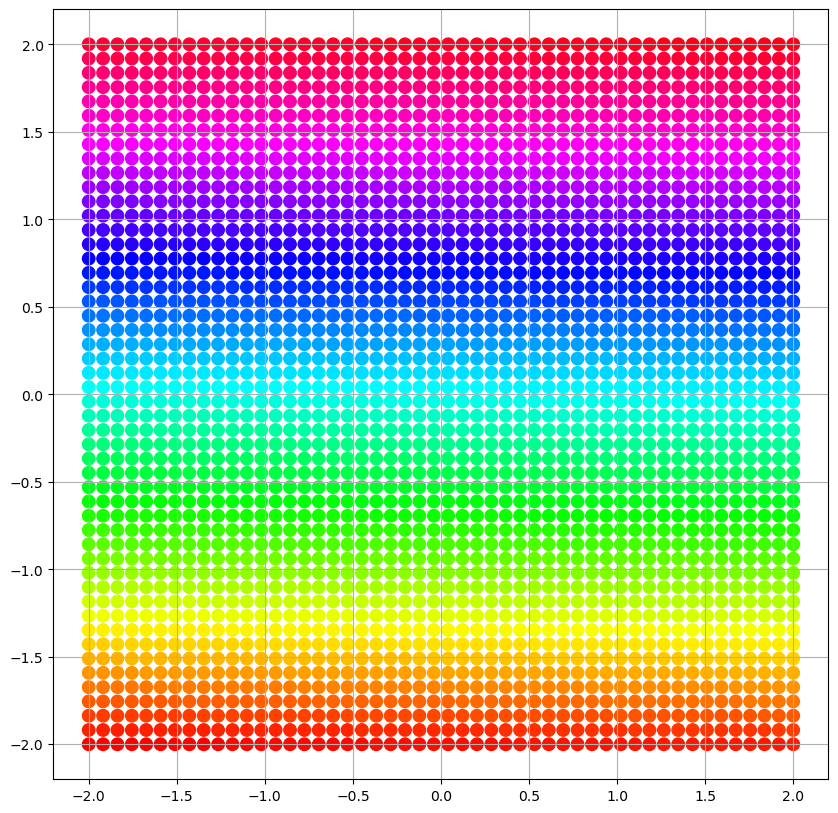

In [9]:
# Defnining the number of points per dimension that will be used.
# Just be careful when you increase this number since we will build a 
# data structure that will require O(N^2) Bytes to be stored!
N=50
# This line creates a NumPy array (or a vector) of 'N' equalspaced points
# from the value -2 to 2.
x = np.linspace(-2,2,N)
# Now, we create the cartesian product between the array 'x' againts 'x'.
# I encourage you to use a small value of 'N' and look at what 'X' and 'Y' are.
X, Y = np.meshgrid(x, x)
# The flatten procedure does a reshape of the matrices 'X' and 'Y' into 1D arrays,
# this is very useful so don't forget it!.
xf = X.flatten()
yf = Y.flatten()
# Already discussed before, now we are however building an array of length 'N^2'.
# This array helps us to provide a different color to each point plotted later.
c  = np.linspace(0,1,N**2)

# Now we will use the Matplotlib library to create a figure.
fig = plt.figure(figsize=(10,10))
# In this particular case we will use the procedure 'scatter' of Matplotlib to
# create a figure with points with different colors. Notice that is not a very
# common procedure or function to use. You will probably use more often 
# 'plt.plot'.
plt.scatter(xf,yf,s=80,c=c,cmap='hsv')
# This line just adds the 'grid' to the plot, it provides a nicer looking for
# the plot and, more important, it is very helpful when one wants to visualize
# the coordinates of a particular point.
plt.grid(True)
# This just show the figure.
plt.show()
# This line is commented. It is used when you would like to save the figure in a file.
# fig.savefig('square_equalspaced.png')

<div id='step1.5' />

## Step 1.5 - This is just a step that will not be used but it is important to understand it!

After we finished the previous step, we can conclude that the points on the same horizonthal have a very similar color. So, to avoid having that, we thought that it may be useful to organize the points in an spiral. So, this is the first try.

<Figure size 1000x1000 with 0 Axes>

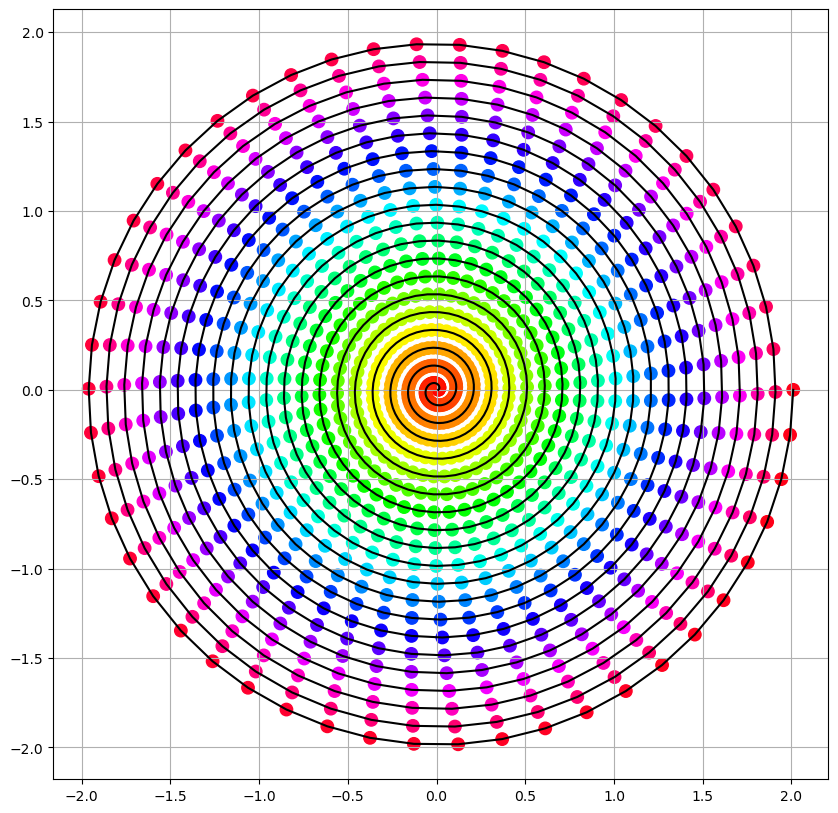

In [10]:
# Number of points in the spiral
M = 1000
# Number of turns of the spiral
n_turns = 20
# Discretization of the points in the spiral.
omega = np.linspace(0,n_turns*2*np.pi,M)
# Here we build a polar representation of the spiral, defining
# the radius 'R' and the angle 'Th', parametrized by the variable
# 'omega'.
# There is a very important computational component here, which is that
# we are operating with the vector ('omega') and scalar components (all the rest of the coefficients).
# This may look simple, but it is in the core of Numpy and vectorization of code!
# If you think how this will be performed in the traditional way in Python you would
# need to write a loop that applies the mathematical transformation element-wise,
# i.e. element by element. This was is simpler, clearer, faster and nicer!
# From the mathematical point of view, we have here the following
# function defined in polar coordinates: r(w)=0.01+2*w/(n_turns*2*np.pi)
R = 0.01+omega*2/(n_turns*2*np.pi)
# Making the transformation to cartesian coordinates, we have:
xp = R*np.cos(omega)
yp = R*np.sin(omega)

# Plotting, already explained before!
plt.figure(figsize=(10,10))
c  = np.linspace(0,1,M)
fig = plt.figure(figsize=(10,10))
# Here we use the 'plot' function! This is just to show the spiral more explicitly.
plt.plot(xp,yp,'k-')
plt.scatter(xp,yp,s=80,c=c,cmap='hsv')
plt.grid(True)
plt.show()
# fig.savefig('spiral_not_equalspaced.png')

<div id='step2' />

## Step 2 - The final spiral!

The previous figure it is indeed an spiral but unfortunately the points start to separate more and more along the curve. So, what we can do? A better idea is just to build the spiral again but having 'equalspaced' points along the spiral. Great idea! But, how do we do that? This is what the following code does.

Nice Warning: The following code will use the few components we have already learned and it will also use some topics we will cover in the class along the semester. This means that you need to enjoy the ride and focus on what you should understand, and look forward to understand the rest along the semester!

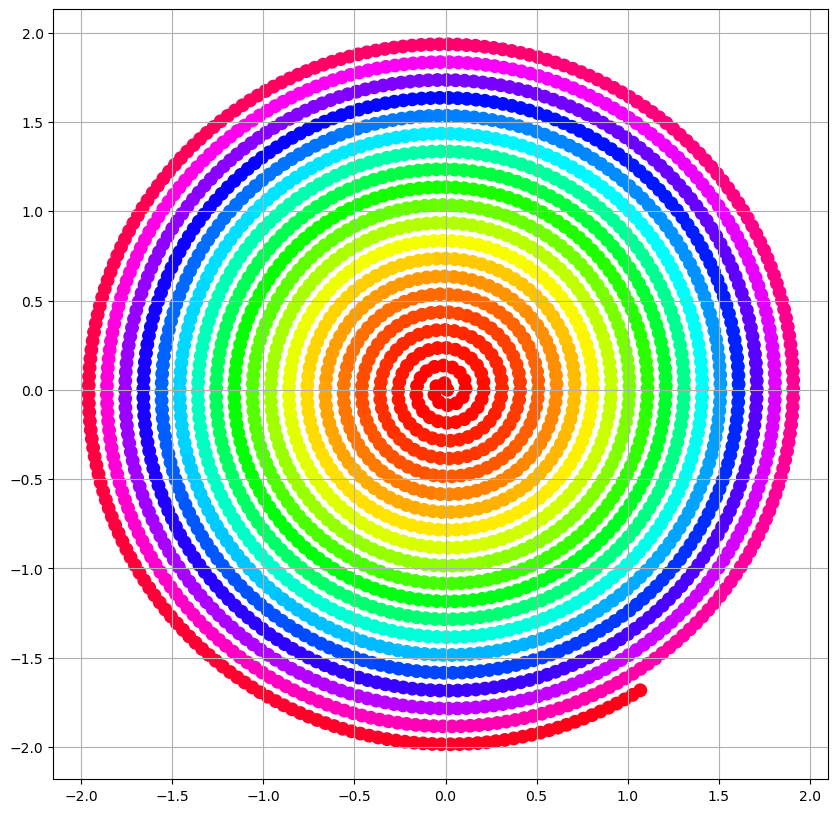

In [11]:
# Number of points to be plotted
M = 2500
# Number of approximated turns around of the spiral.
n_turns = 20
# Initialization of the parametrization angle.
alpha = 0

# Variables used in the parametrization.
# These values were used in the previous plot, here we just given them a name.
delta = 0.01
eta   = 2/(n_turns*2*np.pi)
# This variable defines the arclength values between points.
DL    = 0.05 

# The 'equalspaced' points are obtain computing the arclength of the curve
# connected together with the search of a root of a particular function.
# What it is defined here is the integrand of the arclength integral you
# learned in your previous course of Mathematics!
def integrand(t, delta, eta):
    return np.sqrt(delta**2 + 2*t*delta*eta + (1 + t**2)*eta**2)
# This is the definition of the function that will help us to find
# the correct increment in the angle 'alpha' so the points are
# 'equalspaced'. This function used the target arclength between points,
# which is 'DL' and used the procedure 'quad' that computes the integral
# numericalll for the given integrand and parameters provided.
# The increment is the varible 'beta' here. Mathematically, we are
# solving the sollging equation for 'beta':
# DL=\int_{alpha}^{alpha+beta} integrand(t,delta,eta) dt.
# Notice that we previous problem is equivalent to find a root of:
# f(beta)=DL-\int_{alpha}^{alpha+beta} integrand(t,delta,eta) dt.
# Thus, once we obtain a particular value for 'beta', i.e. beta_hat,
# such that 'f(beta_hat)==0', we conclude that the increment in the
# angle 'alpha' need to set the new point to a distance of arclength
# equal to 'DL' is beta.
f = lambda alpha, beta, delta, eta: DL-quad(integrand, alpha, alpha+beta, args=(delta,eta))[0]

# Just initializing the variables that will store the 'equalspaced' angles.
xp = np.zeros(M)
yp = np.zeros(M)

# Initializing the variables.
R = delta+alpha*eta
xp[0] = R*np.cos(alpha)
yp[0] = R*np.sin(alpha)

for i in np.arange(1,M):
    # Here we use the
    sol = optimize.root_scalar(lambda beta: f(alpha,beta,delta,eta), x0=DL/2, x1=DL)
    beta = sol.root
    
    R = delta+(alpha+beta)*eta
    xp[i] = R*np.cos(alpha+beta)
    yp[i] = R*np.sin(alpha+beta)
    
    alpha = alpha + beta

fig = plt.figure(figsize=(10,10))
c  = np.linspace(0,1,M)
plt.scatter(xp,yp,s=80,c=c,cmap='hsv')
plt.grid(True)
plt.show()
# fig.savefig('spiral_equalspaced.png')

### Now the spiral looks nicer!!

<div id='step3' />

## Step 3 - Why are we doing all of this?!

As mention in the introduction, we want to use this notebook to understand several useful libreries for this class and also the core of numerical linear algebra: linear systems of equations!

Before getting into linear system of equations, we will understand what a matrix does to a vector, i.e. given a vector 'x', what is the matrix 'A' times the vector 'x'? or, the title of this notebook says, what is a 'linear transormation'? For doing this, follow the next code.

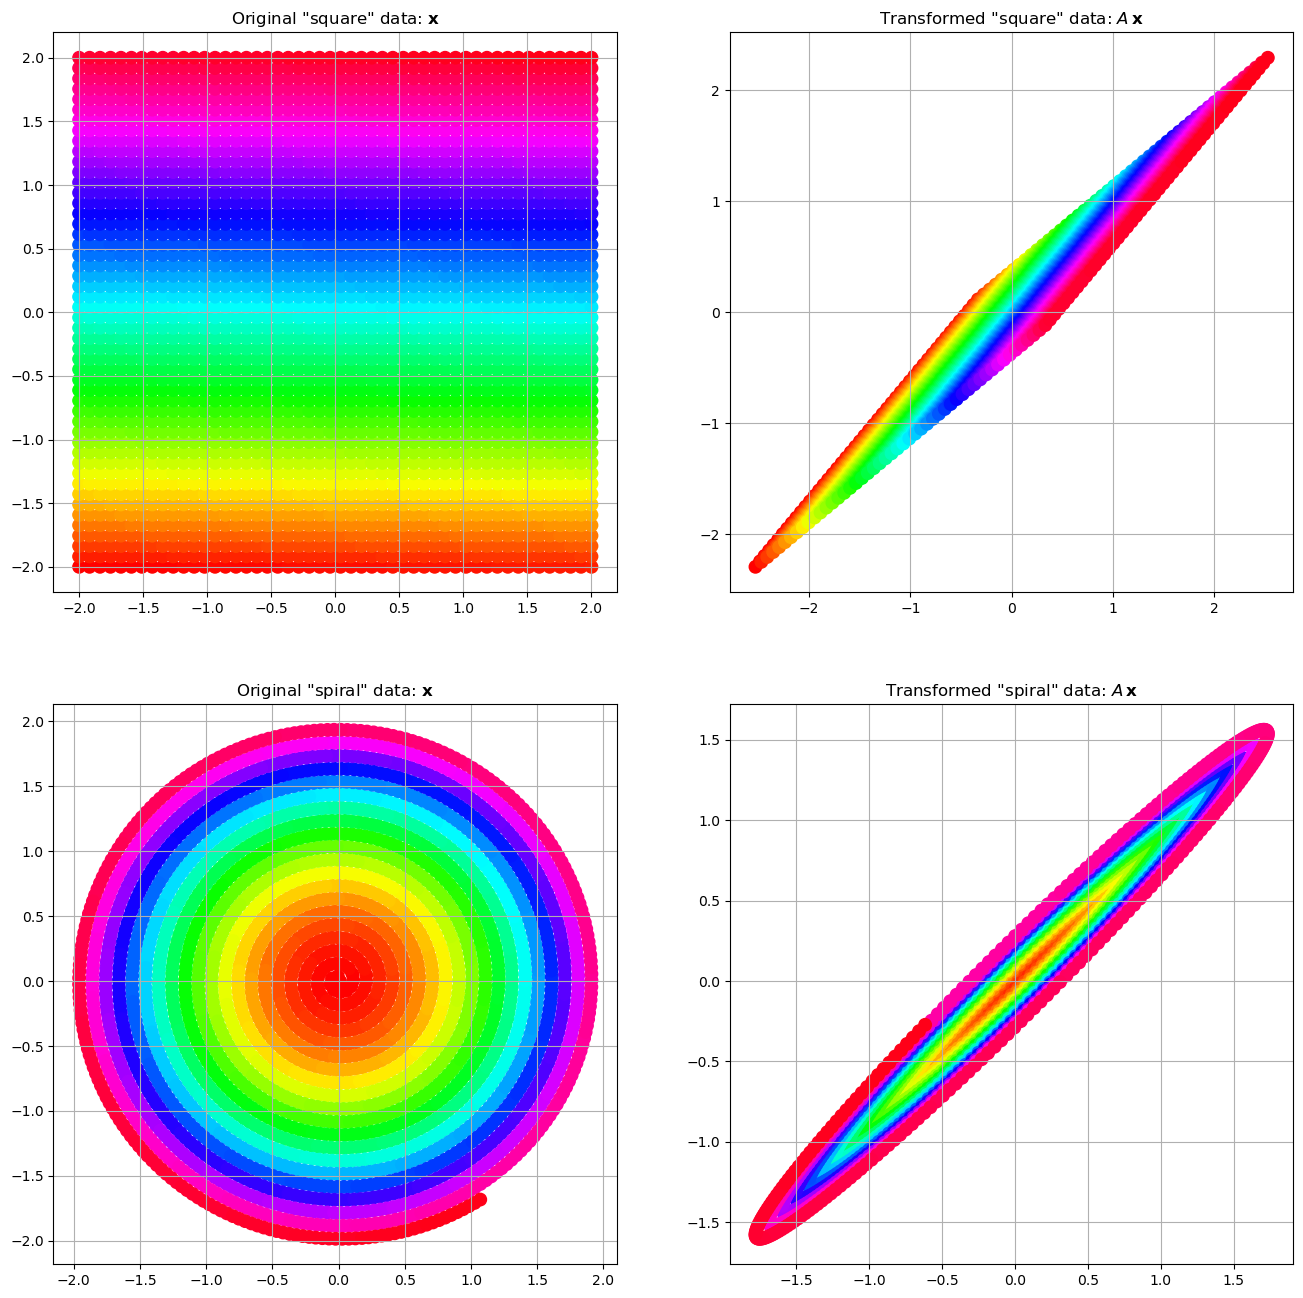

In [12]:
# First, when we play with pseudo-random number in a computer,
# we want to make sure we have reproducible results.
# One way of doing this is to set the seed of the procedure
# to generate random numbers. See the documentation for more
# details. For now, we will just set it at 0, but you can change it.
np.random.seed(0)
# Nest, we build a random 'linear transformation', i.e. the matrix 'A'.
A = np.random.rand(2,2)

# Here, we just collect the data generated before for the points
# in the [-2,2]^2 square. We actually consider them as 'vectors',
# but we only plotted the 'end' of them, this is why you only saw
# 'dots' of different colors.
# The data stores the 'x'-component along the first row and the
# 'y'-component along the second row, so what we have is a matrix
# with 2 rows and 'N^2' columns.
data_square = np.matrix([xf,yf])
# In this varable we store the same way but the data we generated
# for the 'equalspaced' spiral.
data_spiral = np.matrix([xp,yp])

# KEY POINT: This is one of the key point of this analysis. 
# Here we compute what a 'linear transformation' does to a set 
# of vectors! So, all the previous work was for this point.
# The idea of having colored points is to see what happen
# to each point after it is transformed.
# This is done for the 'square' data and the 'spiral' data.
data_transformed_square = np.dot(A,data_square)
# The 'spiral' data was build to remove any doubt about
# the horizontal-color-pattern induced by the 'square' data.
# Notice that the procedure 'np.dot(A,data)' (in both cases),
# computes the 'linear transformation' column by column.
# So, it is a mathematical trsnaformation computed in a 
# 'vectorized' form again! 
data_transformed_spiral = np.dot(A,data_spiral)

# Now, we just split the data between the 'x' and 'y'
# components. We did a little bit of extra work using
# 'np.array' and '.ravel()' so we actually obtain
# arrays at the end and not a numpy matrix. This
# was needed to avoid issue when plotting. There
# must be a better way for doing this, you can find it!
xft = np.array(data_transformed_square[0,:]).ravel()
yft = np.array(data_transformed_square[1,:]).ravel()

# Same procedure but now for the 'spiral' data.
xpt = np.array(data_transformed_spiral[0,:]).ravel()
ypt = np.array(data_transformed_spiral[1,:]).ravel()

# Buiolding image.
fig, axs = plt.subplots(2,2,figsize=(16,16))

axs[0,0].scatter(xf,yf,s=80,c=c,cmap='hsv')
axs[0,0].set_title(r'Original "square" data: $\mathbf{x}$')
axs[0,0].grid(True)

axs[0,1].scatter(xft,yft,s=80,c=c,cmap='hsv')
axs[0,1].set_title(r'Transformed "square" data: $A\,\mathbf{x}$')
axs[0,1].grid(True)

axs[1,0].scatter(xp,yp,s=80,c=c,cmap='hsv')
axs[1,0].set_title(r'Original "spiral" data: $\mathbf{x}$')
axs[1,0].grid(True)

axs[1,1].scatter(xpt,ypt,s=80,c=c,cmap='hsv')
axs[1,1].set_title(r'Transformed "spiral" data: $A\,\mathbf{x}$')
axs[1,1].grid(True)

### Comment:

Now we see how the 'vectors' get modified when multiplied by a matrix! They somehow get rotated and scaled. What is going on then?

<div id='step4' />

## Step 4: Controlling more the transformation.

In the previous step we saw that a set of vectors get rotated and scaled when applied a linear transformation. But since the matrix was random, we did not have that much of control of it. In this step, we will control the matrix a bit more. For doing this, we use that classical rotation matrix (https://en.wikipedia.org/wiki/Rotation_matrix). The advantage of this matrix is that it has two orthonormal columns, i.e. its columns are ortogonals (this is also an important point in this class!!). Recall that two vectors are orthogonal if the inner product (or dot product) is 0. The two ortogonal columns get plotted on the 'left' column plots and on the right we see how they get transformed. We also scaled each column by the 'a' and 'b' coeficients, this way we can scale each column independently.

The visualization of this requires the 'ipywidgets' library. This is a very uselful library for exploring or playing with numerical experiments. The library allow us to modify the parameters on-the-fly and see what it does right away. For this particular case, we allow the user to modify the angle 'theta' of the rotation matrix, and the scalars 'a' and 'b' mentione before. The procedure used is 'interact_manual', this procedure require to set the parameters and the press the 'Run Interact' button. There exist the procedure called 'interact' that does the update right away but when you move the slides bars too quickly the notebook get stuck, so for now, let's use the 'interact_manual' alternative.

In [13]:
def show_linear_transformation(theta=0, a=1, b=1):

    fig, axs = plt.subplots(2,2,figsize=(16,16))
    np.random.seed(0)
    # Building linear transformation, i.e. the matrix 'A'.
    A = np.array([[a*np.cos(theta), -b*np.sin(theta)],[a*np.sin(theta), b*np.cos(theta)]])

    data_square = np.matrix([xf,yf])
    data_spiral = np.matrix([xp,yp])

    data_transformed_square = np.dot(A,data_square)
    data_transformed_spiral = np.dot(A,data_spiral)

    xft = np.array(data_transformed_square[0,:]).ravel()
    yft = np.array(data_transformed_square[1,:]).ravel()

    xpt = np.array(data_transformed_spiral[0,:]).ravel()
    ypt = np.array(data_transformed_spiral[1,:]).ravel()

    xf_max = np.max([np.max(xf),np.max(xft)])
    xf_min = np.min([np.min(xf),np.min(xft)])
    yf_max = np.max([np.max(yf),np.max(yft)])
    yf_min = np.min([np.min(yf),np.min(yft)])
    square_max_dom = np.max([xf_max,-xf_min,yf_max,-yf_min])*1.1

    xp_max=np.max([np.max(xp),np.max(xpt)])
    xp_min=np.min([np.min(xp),np.min(xpt)])
    yp_max=np.max([np.max(yp),np.max(ypt)])
    yp_min=np.min([np.min(yp),np.min(ypt)])
    spiral_max_dom = np.max([xp_max,-xp_min,yp_max,-yp_min])*1.1

    head_width = 0.2
    head_length = 0.2
    # SQUARE
    axs[0,0].scatter(xf,yf,s=80,c=c,cmap='hsv')
    axs[0,0].grid(True)
    # This two lines just add the arrows to the plot.
    axs[0,0].arrow(0,0,1,0,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[0,0].arrow(0,0,0,1,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    # Here, we make sure the domain on the left and on the right are the same, so we see better the linear transformation.
    axs[0,0].axis([-square_max_dom,square_max_dom,-square_max_dom,square_max_dom])

    axs[0,1].scatter(xft,yft,s=80,c=c,cmap='hsv')
    axs[0,1].grid(True)
    axs[0,1].arrow(0,0,a*np.cos(theta),a*np.sin(theta),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[0,1].arrow(0,0,-b*np.sin(theta),b*np.cos(theta),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[0,1].axis([-square_max_dom,square_max_dom,-square_max_dom,square_max_dom])

    # SPIRAL
    axs[1,0].scatter(xp,yp,s=80,c=c,cmap='hsv')
    axs[1,0].grid(True)
    axs[1,0].arrow(0,0,1,0,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[1,0].arrow(0,0,0,1,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[1,0].axis([-spiral_max_dom,spiral_max_dom,-spiral_max_dom,spiral_max_dom])

    axs[1,1].scatter(xpt,ypt,s=80,c=c,cmap='hsv')
    axs[1,1].grid(True)
    axs[1,1].arrow(0,0,a*np.cos(theta),a*np.sin(theta),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[1,1].arrow(0,0,-b*np.sin(theta),b*np.cos(theta),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[1,1].axis([-spiral_max_dom,spiral_max_dom,-spiral_max_dom,spiral_max_dom])

interact_manual(show_linear_transformation, theta=(0.0,2*np.pi,0.1), a=(-2,2,0.1), b=(-2,2,0.1))

interactive(children=(FloatSlider(value=0.0, description='theta', max=6.283185307179586), FloatSlider(value=1.…

<function __main__.show_linear_transformation(theta=0, a=1, b=1)>

### Comment:
Did you see what happened when 'a' or 'b' are zero? Will this produce an issue later one?

<div id='step5' />

## Step 5: The ultimate/supreme/ultra instinc control of the linear transformation!

Finally, we have arrived to the last step. In this step, we will do a few things.
1.- We will allow the two column vectors to move independently. Thus, we will have two angles to manipulate the vectors.
2.- The scaling factors 'a' and 'b' will be kept.
3.- This requires an special explanation, see below.

The third part make the connection to the numerical solution of a linear system of equations.
In particular, we recall that we just learned what happens when we move from the lef-column plots to the right-column plots, but here we will see what happen when we move from the linearly transformed spaced to the 'original' spaced.

The experiment performed before was to obtain 'y' given 'x' as follows: 'y=A*x'. 
Now, the experiment is the opposite: find 'x' given 'y' such that 'A*x=y'. They look similar but they are completely different.
For the second experiment, we need to define 'y', this will be defined as 'y=<1,1>', i.e. the vector '<1,1>'.
This will be plotted as a black diamond on the right-column plots, and will be kept fixed since it is our input now.
On the left-column plot, we will plot as a black diamond the vector 'x', i.e. the solution of 'Ax=<1,1>'.

Computational Warning: In this step we will use the 'interact' procedure for plotting, so just be careful to move the slides slowly, and what for the plot to update, otherwise your may need to wait several minutes until your computer finishes! 

In [15]:
def show_linear_transformation2(theta1=0, theta2=np.pi/2, a=1, b=1):

    fig, axs = plt.subplots(2,2,figsize=(16,16))
    # Building linear transformation, i.e. the matrix 'A'.
    np.random.seed(0)
    A = np.array([[a*np.cos(theta1), b*np.cos(theta2)],[a*np.sin(theta1), b*np.sin(theta2)]])
    # Here we use Numpy to solve the linear system of equations.
    xy = np.linalg.solve(A,[1,1])

    data_square = np.matrix([xf,yf])
    data_spiral = np.matrix([xp,yp])

    data_transformed_square = np.dot(A,data_square)
    data_transformed_spiral = np.dot(A,data_spiral)

    xft = np.array(data_transformed_square[0,:]).ravel()
    yft = np.array(data_transformed_square[1,:]).ravel()

    xpt = np.array(data_transformed_spiral[0,:]).ravel()
    ypt = np.array(data_transformed_spiral[1,:]).ravel()

    xf_max = np.max([np.max(xf),np.max(xft)])
    xf_min = np.min([np.min(xf),np.min(xft)])
    yf_max = np.max([np.max(yf),np.max(yft)])
    yf_min = np.min([np.min(yf),np.min(yft)])
    square_max_dom = np.max([xf_max,-xf_min,yf_max,-yf_min,xy[0],xy[1],-xy[0],-xy[1]])*1.1

    xp_max=np.max([np.max(xp),np.max(xpt)])
    xp_min=np.min([np.min(xp),np.min(xpt)])
    yp_max=np.max([np.max(yp),np.max(ypt)])
    yp_min=np.min([np.min(yp),np.min(ypt)])
    spiral_max_dom = np.max([xp_max,-xp_min,yp_max,-yp_min,xy[0],xy[1],-xy[0],-xy[1]])*1.1

    head_width = 0.2
    head_length = 0.2
    # SQUARE
    axs[0,0].scatter(xf,yf,s=80,c=c,cmap='hsv')
    axs[0,0].grid(True)
    axs[0,0].arrow(0,0,1,0,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[0,0].arrow(0,0,0,1,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[0,0].axis([-square_max_dom,square_max_dom,-square_max_dom,square_max_dom])
    
    axs[0,0].plot(xy[0],xy[1],'dk', markersize=10)

    axs[0,1].scatter(xft,yft,s=80,c=c,cmap='hsv')
    axs[0,1].grid(True)
    axs[0,1].arrow(0,0,a*np.cos(theta1),a*np.sin(theta1),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[0,1].arrow(0,0,b*np.cos(theta2),b*np.sin(theta2),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[0,1].axis([-square_max_dom,square_max_dom,-square_max_dom,square_max_dom])
    
    axs[0,1].plot(1,1,'dk', markersize=10)

    # SPIRAL
    axs[1,0].scatter(xp,yp,s=80,c=c,cmap='hsv')
    axs[1,0].grid(True)
    axs[1,0].arrow(0,0,1,0,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[1,0].arrow(0,0,0,1,head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[1,0].axis([-spiral_max_dom,spiral_max_dom,-spiral_max_dom,spiral_max_dom])
    
    axs[1,0].plot(xy[0],xy[1],'dk', markersize=10)

    axs[1,1].scatter(xpt,ypt,s=80,c=c,cmap='hsv')
    axs[1,1].grid(True)
    axs[1,1].arrow(0,0,a*np.cos(theta1),a*np.sin(theta1),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='left')
    axs[1,1].arrow(0,0,b*np.cos(theta2),b*np.sin(theta2),head_width=head_width, head_length=head_length, fc='k', ec='k', linewidth =3, length_includes_head=True, shape='right')
    axs[1,1].axis([-spiral_max_dom,spiral_max_dom,-spiral_max_dom,spiral_max_dom])
    
    axs[1,1].plot(1,1,'dk', markersize=10)
    plt.show()

interact(show_linear_transformation2, theta1=(0.0,2*np.pi,0.1), theta2=(0.0,2*np.pi,0.1), a=(-2,2,0.05), b=(-2,2,0.05))

interactive(children=(FloatSlider(value=0.0, description='theta1', max=6.283185307179586), FloatSlider(value=1…

<function __main__.show_linear_transformation2(theta1=0, theta2=1.5707963267948966, a=1, b=1)>

<div id='finalComments' />

## Final Comments:
- Did you see what happens with the solution of the linear system of equations when 'a' or 'b' are zero?
- Did you see what happens with the solution of the linear system of equations when the two columns of 'A' are parallel?
- Did you learn something interesting?

<div id='acknowledgements' />

# Acknowledgements
* _Material originally created by professor Claudio Torres_ (`ctorres@inf.utfsm.cl`) v.0.1. DI UTFSM. March 2021.
* _Update March 2022 - v0.11 - C.Torres_ : Adding emblem.